## Preprocessing

In [1]:
import os
import numpy as np

TRAIN_PATH = "./yawn_dataset/train"
TEST_PATH = "./yawn_dataset/test"

def get_filenames_labels(split="train"):
    base_path = TRAIN_PATH if split=="train" else TEST_PATH
    files_closed = [os.path.join(os.path.join(base_path, "no_yawn", x)) for x in os.listdir(os.path.join(base_path, "no_yawn"))]
    labels_closed = np.zeros(len(files_closed))
    files_opened = [os.path.join(os.path.join(base_path, "yawn", x)) for x in os.listdir(os.path.join(base_path, "yawn"))]
    labels_opened = np.ones(len(files_opened))
    
    files_all = files_closed + files_opened
    labels_all = np.concatenate((labels_closed, labels_opened), axis=0)
    return files_all, labels_all

filenames, labels = get_filenames_labels()
filenames_test, labels_test = get_filenames_labels(split="test")

In [2]:
from sklearn.model_selection import train_test_split

VAL_RATIO = 0.15

filenames_train, filenames_val, labels_train, labels_val = train_test_split(filenames, labels, test_size=VAL_RATIO, 
    random_state=42, shuffle=True, stratify=labels)

In [3]:
print("TEST SIZE:", len(filenames_test))
print("TRAIN_SIZE:", "-train:", len(filenames_train), "-val:", len(filenames_val))

TEST SIZE: 215
TRAIN_SIZE: -train: 1048 -val: 185


In [4]:
import tensorflow as tf

IMAGE_HEIGHT = IMAGE_WIDTH = 512

def load_image(img_path, label, height, width):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [height, width])
    return image, label
    

dataset_train = tf.data.Dataset.from_tensor_slices((filenames_train, labels_train))
train_images = dataset_train.map(lambda x, y: load_image(x, y, IMAGE_HEIGHT, IMAGE_WIDTH), num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset_val = tf.data.Dataset.from_tensor_slices((filenames_val, labels_val))
val_images = dataset_val.map(lambda x, y: load_image(x, y, IMAGE_HEIGHT, IMAGE_WIDTH), num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [5]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        self.augment_inputs = tf.keras.Sequential([
            tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
            #tf.keras.layers.RandomRotation(0.1),
        ])
        self.HSV = [0.3, 0.3, 0.3]
        self.rescale = tf.keras.layers.Rescaling(1./255)

    def hsv(self, image):
        if tf.random.uniform([]) < self.HSV[0]:
            image = tf.image.adjust_hue(image, tf.random.uniform([], -0.1, 0.1))
        if tf.random.uniform([]) < self.HSV[1]:
            image = tf.image.adjust_saturation(image, tf.random.uniform([], 0, 2))
        if tf.random.uniform([]) < self.HSV[2]:
            image = tf.image.adjust_brightness(image, tf.random.uniform([], -0.2, 0.2))
        return image

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        inputs = self.hsv(inputs)
        inputs = self.rescale(inputs)
        return inputs, labels

In [6]:
EPOCHS = 100
BATCH_SIZE = 16
TRAIN_LENGTH = len(filenames_train)
BUFFER_SIZE = 200
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_batches = (
    train_images
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

val_batches = val_images.batch(BATCH_SIZE)

[0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.]


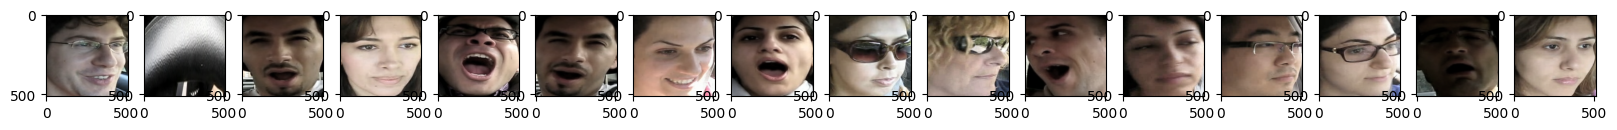

In [7]:
import matplotlib.pyplot as plt
import numpy as np

for i, data in enumerate(train_batches):
    imgs = data[0]
    labels = data[1]
    print(labels.numpy())
    f, ax = plt.subplots(1,BATCH_SIZE, figsize=(20,5))
    for j, img in enumerate(imgs):
        img = (img.numpy()*255).astype(np.uint8)
        ax[j].imshow(img)
    plt.show()
    break

## Create model and train

In [8]:
IMG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

In [9]:
base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation="sigmoid")
  # tf.keras.layers.Conv2D(32, 3, activation='relu'),
  # tf.keras.layers.Dropout(0.2),
  # tf.keras.layers.GlobalAveragePooling2D(),
  # tf.keras.layers.Dense(1, activation="sigmoid"),
  #tf.keras.layers.Dense(2, activation="softmax"),
])

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
            #   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=['accuracy'])

In [11]:
checkPoint_callback = tf.keras.callbacks.ModelCheckpoint("./checkpoints/weights{epoch:04d}.h5",
                                    save_weights_only=False, period=5)
tf.config.get_visible_devices()
model_history = model.fit(train_batches, epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
            validation_data=val_batches, callbacks=[checkPoint_callback])

Epoch 1/100
65/65 [==============================] - 196s 3s/step - loss: 0.3707 - accuracy: 0.8510 - val_loss: 0.7693 - val_accuracy: 0.6432
Epoch 2/100
65/65 [==============================] - 184s 3s/step - loss: 0.0629 - accuracy: 0.9826 - val_loss: 0.5127 - val_accuracy: 0.7297
Epoch 3/100
65/65 [==============================] - 175s 3s/step - loss: 0.0359 - accuracy: 0.9903 - val_loss: 0.6992 - val_accuracy: 0.6216
Epoch 4/100
65/65 [==============================] - 180s 3s/step - loss: 0.0069 - accuracy: 0.9971 - val_loss: 0.5344 - val_accuracy: 0.7838
Epoch 5/100
65/65 [==============================] - 166s 3s/step - loss: 0.0479 - accuracy: 0.9855 - val_loss: 0.6509 - val_accuracy: 0.6378
Epoch 6/100
65/65 [==============================] - 173s 3s/step - loss: 0.0042 - accuracy: 0.9971 - val_loss: 0.8170 - val_accuracy: 0.5784
Epoch 7/100
65/65 [==============================] - 163s 3s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.9649 - val_accuracy: 0.5784
Epoch 

KeyboardInterrupt: 

## Evaluate

In [ ]:
model = tf.keras.models.load_model("checkpoints/weights0030.h5")

dataset_test = tf.data.Dataset.from_tensor_slices((filenames_test, labels_test))
test_images = dataset_test.map(lambda x, y: load_image(x, y, IMAGE_HEIGHT, IMAGE_WIDTH), num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
from tqdm import tqdm

y_true = []
y_pred = []
for element in tqdm(test_images.as_numpy_iterator()):
    image, label = element
    y_true.append(label)
    image_to_predict = image[None, :,:,:]
    labels_probs = model.predict(image_to_predict, verbose=0)[0]
    label_pred = np.argmax(labels_probs)
    y_pred.append(label_pred)

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

conf_mat = confusion_matrix(y_true, y_pred)
print("Confusion matrix")
print(conf_mat)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='binary')
print("Precision", precision)
print("Recall", recall)
print("F1", f1)